# Module imports

In [1]:
import tensorflow as tf
import numpy as np
import os

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(1234)

import datasets
import losses
import cnns
import model

In [2]:
import shutil

folder_path = 'MEBeauty/vgg16'

# Check if the folder exists
if os.path.exists(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # Remove file or symbolic link
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # Remove directory and its contents
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')
else:
    print(f"The folder {folder_path} does not exist.")

# Model selection

In [3]:
"""
Select model type to be trained
cnns.ResNet50 - Residual Net model
cnns.SENet50 - Squeeze Net model
cnns.VGG16 - VGG16 model
"""
#get_cnns = cnns.ResNet50
#get_cnns = cnns.SENet50
get_cnns = cnns.VGG16

#Initialise dataset with model type
dataset = datasets.MEBeauty(get_cnns()[0])

(1638, 14, 14, 512) (456, 14, 14, 512)
(1638, 10) (456, 10)
(183, 14, 14, 512) (183, 10)
Val generator saved to ./MEBeauty/vgg16/(14, 14, 512)/val.pkl
Train generator saved to ./MEBeauty/vgg16/(14, 14, 512)/train.pkl
Test generator saved to ./MEBeauty/vgg16/(14, 14, 512)/test.pkl


# Model training

In [4]:
"""
Training metrics to evaluate model performance
Check 'losses.py' file for implementation
"""
metrics = [
    tf.keras.metrics.KLDivergence(),
    losses.EarthMoversDistance(),
    losses.MeanAbsoluteError(dataset.n),
    losses.RootMeanSquaredError(dataset.n),
    losses.PearsonCorrelation(dataset.n),
    losses.MeanAbsoluteError(dataset.n, mode="std"),
    losses.RootMeanSquaredError(dataset.n, mode="std"),
    losses.PearsonCorrelation(dataset.n, mode="std"),
    losses.MeanAbsoluteError(dataset.n, mode="skew"),
    losses.RootMeanSquaredError(dataset.n, mode="skew"),
    losses.PearsonCorrelation(dataset.n, mode="skew")
]

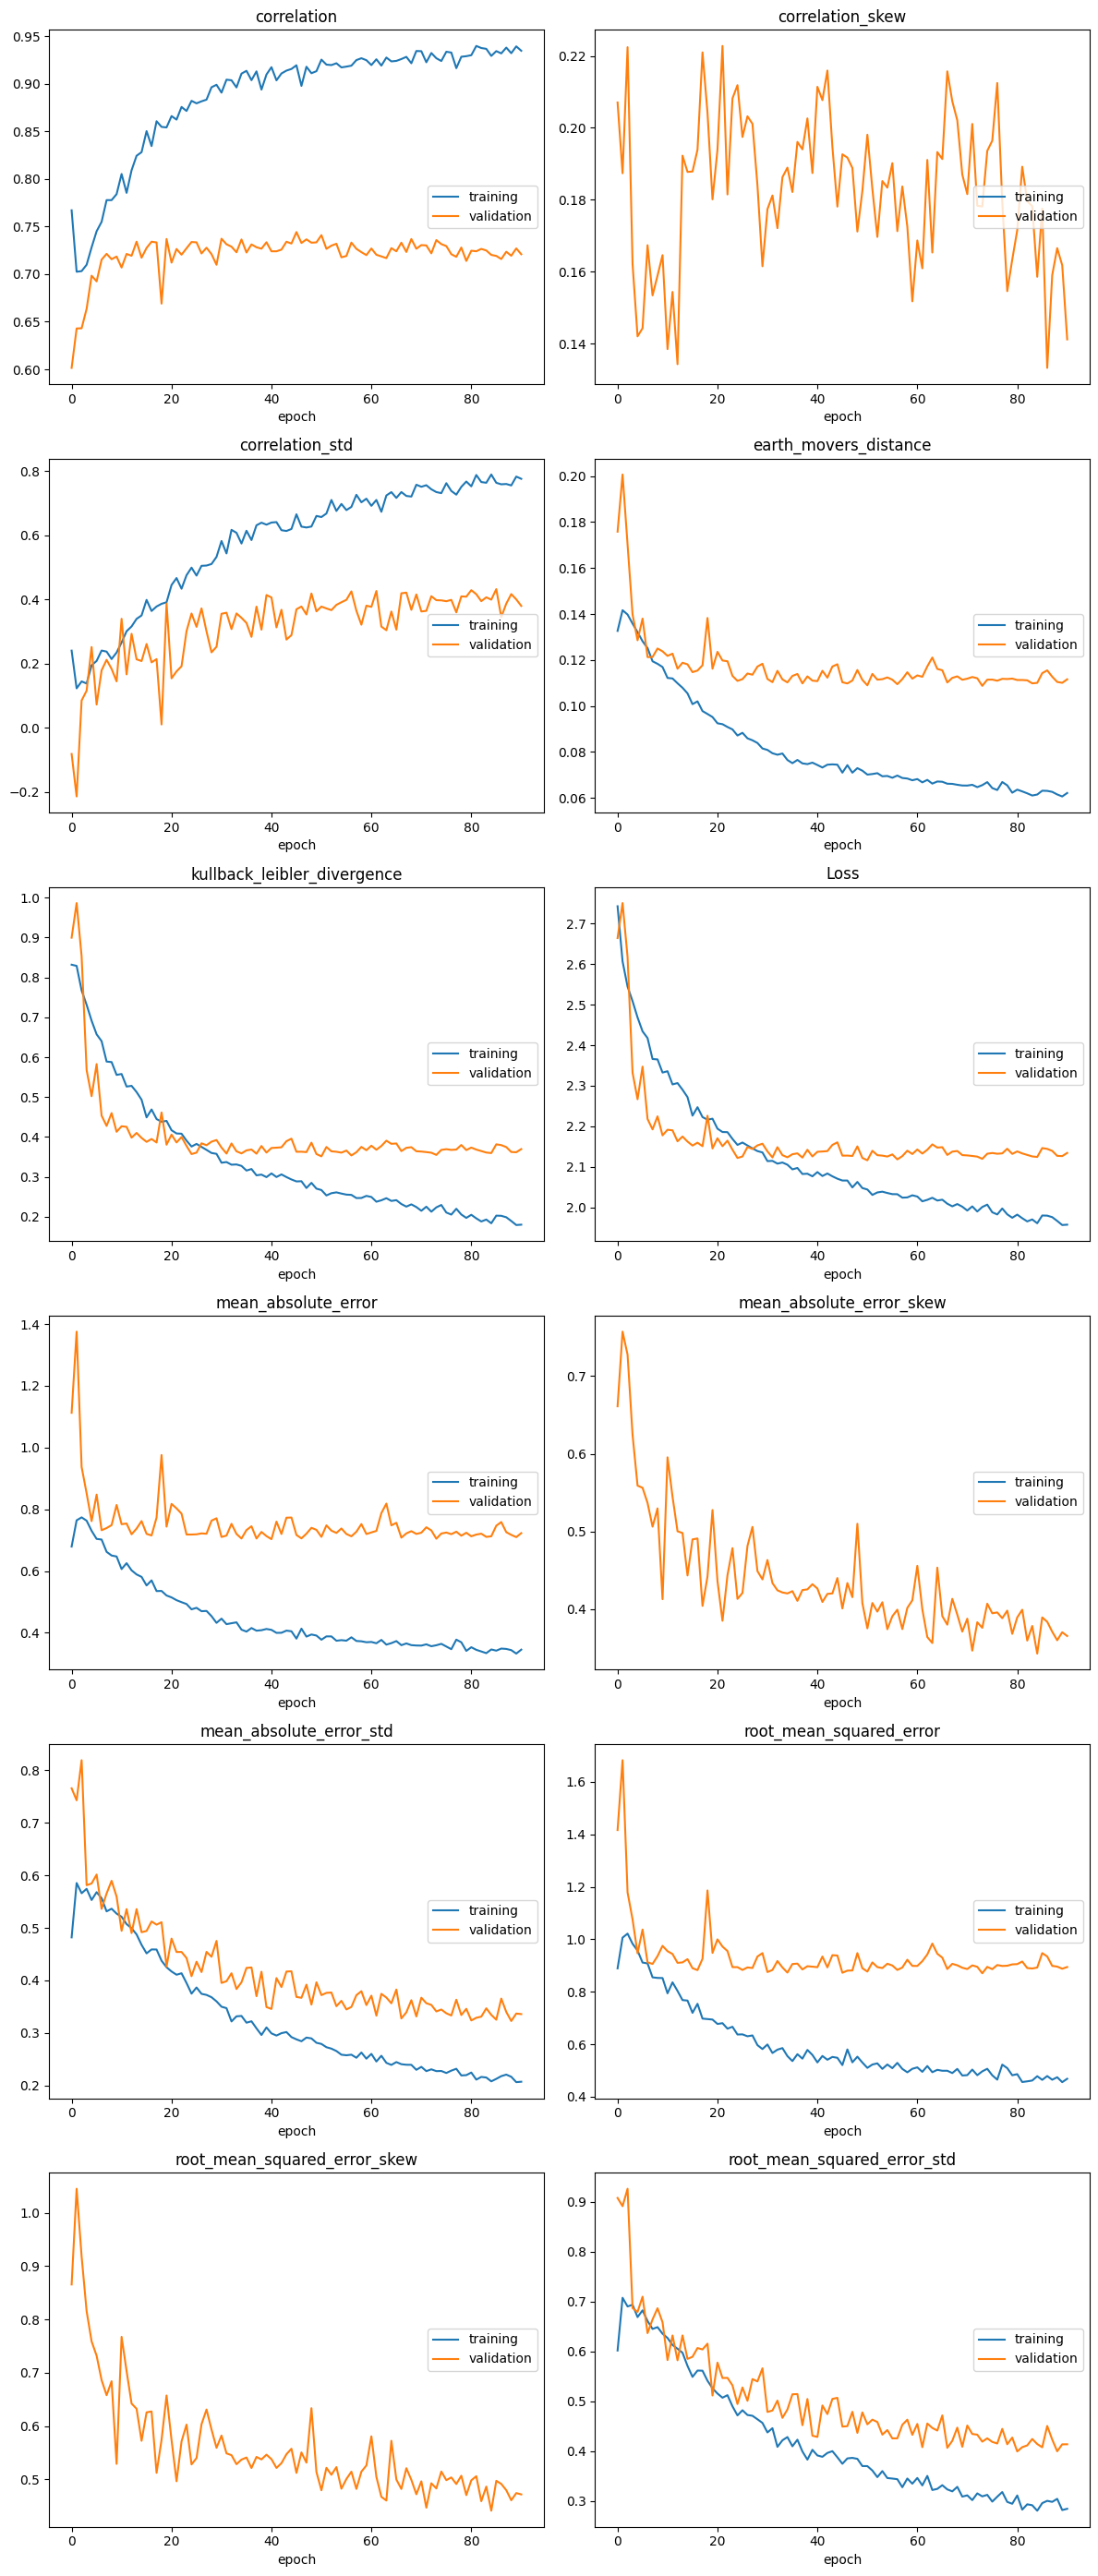

correlation
	training         	 (min:    0.703, max:    0.940, cur:    0.935)
	validation       	 (min:    0.602, max:    0.744, cur:    0.721)
correlation_skew
	training         	 (min:      nan, max:      nan, cur:      nan)
	validation       	 (min:    0.133, max:    0.223, cur:    0.141)
correlation_std
	training         	 (min:    0.123, max:    0.790, cur:    0.777)
	validation       	 (min:   -0.214, max:    0.433, cur:    0.380)
earth_movers_distance
	training         	 (min:    0.061, max:    0.142, cur:    0.062)
	validation       	 (min:    0.109, max:    0.201, cur:    0.112)
kullback_leibler_divergence
	training         	 (min:    0.180, max:    0.832, cur:    0.180)
	validation       	 (min:    0.352, max:    0.986, cur:    0.370)
Loss
	training         	 (min:    1.957, max:    2.743, cur:    1.957)
	validation       	 (min:    2.116, max:    2.751, cur:    2.134)
mean_absolute_error
	training         	 (min:    0.332, max:    0.774, cur:    0.345)
	validation       	 (m

In [5]:
"""
Ensemble training loop
"""
y_pred_total = np.zeros(dataset.test.y.shape)
time_total = 0 #Total time required to train the model
k = 2 # The number of models to be trained (if building an ensemble)
m = model.Model(get_cnns, dataset) #Initialise model

for i in range(k):
    m.construct(supress=True)
    """
    Compile model with a given loss function
    cce - Categorical Cross Entropy
    l2 - 2-Norm loss
    emd - Earth Mover's Distance
    """
    m.compile("cce", metrics=metrics)
    y_pred, time = m.train(
        iteration=i,
        monitor="val_mean_absolute_error", #Early stopping metric
        save=True,
        predict=True)
    y_pred_total += y_pred 
    time_total += time

y_pred_total /= k

In [ ]:
y_pred_total[0]

array([0.20859921, 0.15864931, 0.16053355, 0.3064842 , 0.38282502,
       0.3049107 , 0.24714997, 0.08734024, 0.10870659, 0.03480125],
      dtype=float32)

In [22]:
dataset.test.y[0]

array([0.05882353, 0.05882353, 0.05882353, 0.11764706, 0.05882353,
       0.1764706 , 0.1764706 , 0.1764706 , 0.05882353, 0.05882353],
      dtype=float32)

# Inference
## Interpreting Model Predictions
The model outputs a probability distribution across 10 beauty rating categories (1-10). Each value represents the probability that a face belongs to the corresponding rating category.

## Example
If the model output is `[0, 0, 0, 0, 0, 0, 0, 0, 0.8, 0.2]`, this means:
- 80% probability the face rates as a 9
- 20% probability the face rates as a 10
- 0% probability for all ratings 1-8

## Calculating Overall Beauty Rating
We calculate a weighted average (expected value) to determine a single beauty score:
```
Overall rating = Σ(rating × probability)
```

In our example: 0.8 × 9 + 0.2 × 10 = 9.2

## Measuring Conventional vs. Unconventional Beauty
The standard deviation of the probability distribution provides insight into how conventional the beauty is:

- **High mean + Low standard deviation**: Conventionally beautiful face (consistent ratings)
- **High mean + High standard deviation**: Unconventionally beautiful face (more divided opinions)

This approach allows us to quantify not just the perceived beauty level but also how universally that perception might be held.

In [6]:
m.model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 14, 14, 512)]     0         
_________________________________________________________________
vgg16_stage5 (Functional)    (None, 7, 7, 512)         7079424   
_________________________________________________________________
MLP (Functional)             (None, 10)                3313546   
Total params: 10,392,970
Trainable params: 10,342,538
Non-trainable params: 50,432
_________________________________________________________________


In [8]:
import cv2

def preprocess_image(image, feature_extractor, mean=None, std=None):
    """
    Preprocess an image according to the same steps used in the Dataset class
    
    Args:
        image: cv2 loaded image
        feature_extractor: the model being used
        mean: optional, mean values for each channel
        std: optional, standard deviation values for each channel
        
    Returns:
        preprocessed image ready for prediction
    """
    # Resize image to match model's input shape
    target_size = (feature_extractor.input_shape[1], feature_extractor.input_shape[2])
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_CUBIC)
    
    # Convert from BGR to RGB if necessary
    # Note: cv2 loads as BGR by default, so this step actually reverses 
    # the BGR to RGB conversion in the original code
    # image = image[..., ::-1]  # Uncomment this if your image is in RGB format
    
    # Zero center each channel
    if mean is None:
        mean = np.array([
            np.mean(image[..., 0]),
            np.mean(image[..., 1]),
            np.mean(image[..., 2])
        ], np.float32)
    
    image = image - mean
    
    # If using VGG16, normalize by std
    if feature_extractor._name == "vgg16":
        print("feature extractor is vgg16")
        if std is None:
            std = np.array([
                np.std(image[..., 0]),
                np.std(image[..., 1]),
                np.std(image[..., 2])
            ], np.float32)
        image = image / std
    
    # Add batch dimension if needed
    if len(image.shape) == 3:
        image = np.expand_dims(image, axis=0)
    
    return image

In [ ]:
base_cnn, _, _ = get_cnns()

In [ ]:
dataset.mean # needed for preprocessing inference images

array([ 95.695145, 109.0723  , 140.87898 ], dtype=float32)

In [ ]:
dataset.std # needed for preprocessing inference images

array([57.07819 , 59.327507, 68.62396 ], dtype=float32)

In [ ]:
# We assume this image has face cropped. Mediapipe should be used to detect the face and crop it first
# Mediapipe docs: https://ai.google.dev/edge/mediapipe/solutions/vision/face_detector
img = cv2.imread("C:/Users/ahmed/Downloads/1.jpg")

# Preprocess it
preprocessed_img = preprocess_image(img, base_cnn, dataset.mean, dataset.std)

# Now you can pass it to your model for prediction
base_model_output = base_cnn.predict(preprocessed_img)
predictions = m.model.predict(base_model_output)

# Ratings from 1 to 10
ratings = np.arange(1, 11)

# Calculate mean
mean = np.sum(ratings * predictions)

# Calculate variance
variance = np.sum(predictions * (ratings - mean) ** 2)

# Standard deviation is square root of variance
std_dev = np.sqrt(variance)

print("Beauty rating:", mean)
print("Standard deviation:", std_dev)

feature extractor is vgg16
Beauty rating: 7.423057494685054
Standard deviation: 2.3725645593378175


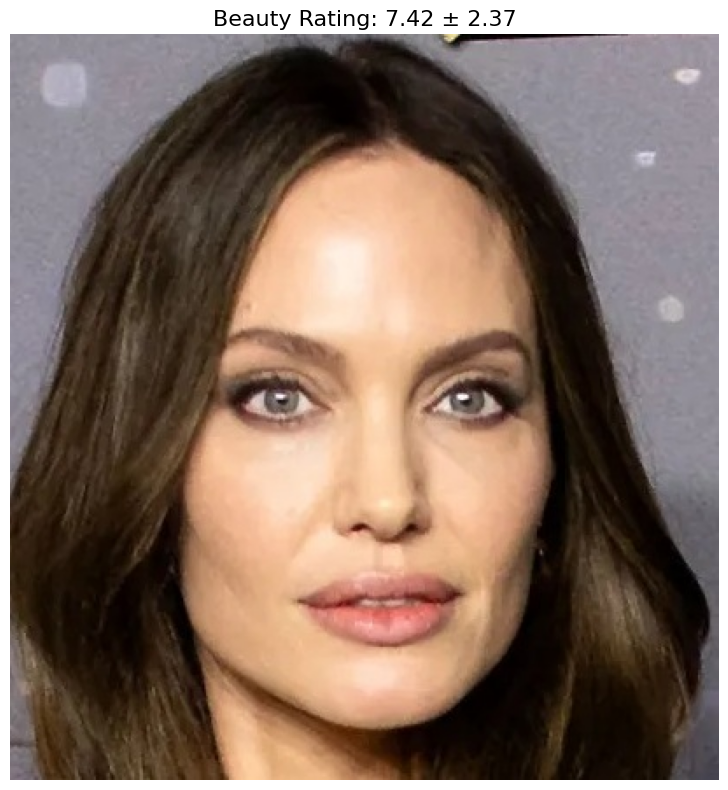

In [19]:
import matplotlib.pyplot as plt

# Convert the image from BGR to RGB color space for matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Create a figure and display the image
plt.figure(figsize=(10, 8))
plt.imshow(img_rgb)

# Set the title with beauty score and standard deviation
plt.title(f"Beauty Rating: {mean:.2f} ± {std_dev:.2f}", fontsize=16)

# Remove axis ticks for cleaner display
plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

# Code to generate plots for latex

In [18]:
# """
# Function to output the metric results on the test set
# into a latex table format
# """
# def results(y_test, y_pred, end="	", supress=False):
#     if not supress: 
#         print(f"{tf.keras.metrics.KLDivergence()(y_test, y_pred):.4}", end=end)
#         print(f"{metrics[1](y_test, y_pred):.3}")

#     res = 0
#     for i in range(2,len(metrics)):
#         if (i-1) % 3 == 0:
#             r = metrics[i](y_test, y_pred).numpy()[0][0]
#             if not supress:
#                 print(f"{str(r)[0:5]}", end=end)
#                 print()
#         else:
#             r = metrics[i](y_test, y_pred).numpy()
#             if i == 2:
#                 res = r
#             if not supress: print(f"{str(r)[0:5]}", end=end)

#     return res

In [16]:
# """
# The following code produces a graph of the evaluation
# of the averaged prediction on the MEBeauty test set 
# across a range of ensemble sizes
# """
# import matplotlib.pyplot as plt
# import pickle
# with open("MEBeauty/vgg16/(14, 14, 512)/test.pkl", "rb") as f:
#     y_test = pickle.load(f).y

# x = np.arange(1,6)

# plt.figure(figsize=(4,3))
# for l in ["cce","l2","emd"]:
#     y = []
#     for k in x:
#         y_pred_total = np.zeros_like(y_test)

#         for i in range(k):
#             for bb in ["resnet50","senet50","vgg16"]:
#                 path = "./MEBeauty/"+bb+"/"
#                 y_pred_total += np.load(path+l+f"/y_pred_{i}.npy")

#         y_pred_total /= 3*k
#         y.append(results(y_test, y_pred_total, end=" & ", supress=True))

#     plt.plot(x,y,label=l.upper())

# plt.title("$R_k$$S_k$$V_k$")
# plt.ylabel("MAE")
# plt.xlabel("k")
# plt.xticks(x)
# plt.legend(loc="upper right", title="Loss")
# #plt.savefig("C:/Users/ugail/Downloads/rsv.png", bbox_inches='tight', dpi=500)
# plt.show()

In [17]:
# """
# The following code averages 2 predictions from each trained
# model type (trained using cce loss) and produces an evaluation
# table
# """
# k = 2
# l = "cce"

# import pickle
# with open(path+"(14, 14, 1024)/test.pkl", "rb") as f:
#     y_test = pickle.load(f).y

# y_pred_total = np.zeros_like(y_test)

# for path in ["./MEBeauty/vgg16/",
#              "./MEBeauty/senet50/",
#              "./MEBeauty/resnet50/"]:
#     for i in range(k):
#         y_pred_total += np.load(path+l+f"/y_pred_{i}.npy")

# y_pred_total /= k*3

# results(y_test, y_pred_total, end=" & ")